# Eyup - logistic Regression Model

## Packages and Libraries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  
sns.set(style="darkgrid")  


from sklearn.metrics import confusion_matrix as sk_confusion_matrix, ConfusionMatrixDisplay,roc_curve, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from keras.datasets import fashion_mnist
import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')


tf.get_logger().setLevel('INFO')

## Data Ingestion

In [2]:
#Data Ingestion
X_train = pd.read_csv("cleaned_x_train.csv")
Y_train = pd.read_csv("cleaned_y_train.csv")

X_val   = pd.read_csv("cleaned_x_val.csv")
Y_val   = pd.read_csv("cleaned_y_val.csv")

X_test  = pd.read_csv("cleaned_x_test.csv")
Y_test  = pd.read_csv("cleaned_y_test.csv")

X_test_raw = pd.read_csv("cleaned_x_test.csv") #for sub group analysis

## Data Check

In [3]:
#Shape of the data

datasets = {
    "X_train": X_train,
    "Y_train": Y_train,
    "X_val": X_val,
    "Y_val": Y_val,
    "X_test": X_test,
    "Y_test": Y_test
}

for name, arr in datasets.items():
    print(f"{name} shape: {arr.shape}")

X_train shape: (24158, 24)
Y_train shape: (24158, 1)
X_val shape: (5178, 24)
Y_val shape: (5178, 1)
X_test shape: (5177, 24)
Y_test shape: (5177, 1)


In [4]:
pd.DataFrame({
    "X_min": X_train.min(),
    "X_max": X_train.max(),
    "Y_min": Y_train.min(),
    "Y_max": Y_train.max()})

,X_min,X_max,Y_min,Y_max
ACEADNED,0.0,4.0,NaN,NaN
ACEADSAF,0.0,4.0,NaN,NaN
ACEDEPRS,0.0,1.0,NaN,NaN
ACEDIVRC,0.0,8.0,NaN,NaN
ACEDRINK,0.0,1.0,NaN,NaN
ACEDRUGS,0.0,1.0,NaN,NaN
ACEHURT1,0.0,2.0,NaN,NaN
ACEPRISN,0.0,1.0,NaN,NaN
ACEPUNCH,0.0,2.0,NaN,NaN
ACESWEAR,0.0,2.0,NaN,NaN


## Data Scaling

In [5]:
# scale some x features and convert y values to 0/1
cols_to_scale = ["ACEHURT1", "ACEPUNCH", "ACESWEAR", "ACETOUCH", "ACETTHEM",
                "ACEADNED", "ACEADSAF", "ACEDIVRC", "_SMOKER3", "_EDUCAG",
                "MENTHLTH", "PHYSHLTH", "_AGE80", "ACE_SCORE"]

scaler = StandardScaler()

X_train[cols_to_scale ] = scaler.fit_transform(X_train[cols_to_scale])
X_val[cols_to_scale]   = scaler.transform(X_val[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

Y_train = Y_train.squeeze().astype(int)
Y_val   = Y_val.squeeze().astype(int)
Y_test  = Y_test.squeeze().astype(int)

## Baseline

In [6]:
#1 number of risky drinkers images
print("Number of Risky Drinkers:", sum(Y_train == 1))
#2 number of non-risky drinkers
print("Number of Non-Risky Drinkers:", sum(Y_train == 0))
#3 majority class in Y_train
class_counts = np.bincount(Y_train)
majority = class_counts.argmax()
if majority == 0:
    print("Majority Class: Non-Risky Drinkers")
else:
    print("Majority Class: Risky Drinkers")
#4 accuracy of majority class in Y_train
print("Accuracy of The Majority Class/ Baseline Accuracy:", class_counts.max() / len(Y_train))

Number of Risky Drinkers: 9110
Number of Non-Risky Drinkers: 15048
Majority Class: Non-Risky Drinkers
Accuracy of The Majority Class/ Baseline Accuracy: 0.6228992466263763


## Downsampling The Majority Class (Non-Risky Drinkers)

In [7]:
maj_idx = Y_train[Y_train == 0].index   
min_idx = Y_train[Y_train == 1].index 

majority_down_idx = resample(
    maj_idx,
    replace=False,
    n_samples=len(min_idx),   
    random_state=42
)

downsampled_idx = np.random.RandomState(42).permutation(list(majority_down_idx) + list(min_idx))

X_train_down = X_train.loc[downsampled_idx]
Y_train_down = Y_train.loc[downsampled_idx]

## Building Initial Logistic Regression Model

In [8]:
def build_model(num_features, learning_rate):
  """
  Creates a basic logistic regression model with one Dense layer and a sigmoid
  activation. All weights and the bias start at 1, and a random seed keeps the
  results consistent. The model uses SGD with the given learning rate and is
  compiled with binary cross-entropy and accuracy.
  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)


  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=1,        
      input_shape=(num_features,),  
      use_bias=True,              
      activation="sigmoid",
      kernel_initializer=tf.keras.initializers.Ones(),  
      bias_initializer=tf.keras.initializers.Zeros(),
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


  model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    
  return model

Epoch 1/15


2025-12-11 03:00:51.325258: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-11 03:00:51.325289: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-11 03:00:51.325295: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-11 03:00:51.325544: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-11 03:00:51.325557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-12-11 03:00:51.626560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4915 - loss: 2.5479 - val_accuracy: 0.5037 - val_loss: 2.5925
Epoch 2/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4915 - loss: 2.5249 - val_accuracy: 0.5019 - val_loss: 2.5706
Epoch 3/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4912 - loss: 2.5020 - val_accuracy: 0.5015 - val_loss: 2.5488
Epoch 4/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4913 - loss: 2.4793 - val_accuracy: 0.5014 - val_loss: 2.5271
Epoch 5/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4915 - loss: 2.4568 - val_accuracy: 0.5010 - val_loss: 2.5056
Epoch 6/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4917 - loss: 2.4345 - val_accuracy: 0.4996 - val_loss: 2.4842
Epoch 7/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4917 - loss: 2.4123 - val_accuracy: 0.4985 - val_loss: 2.4630
Epoch 8/15
570/570 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4909 - loss: 2.3903 - val_accuracy: 0.4977 - val_

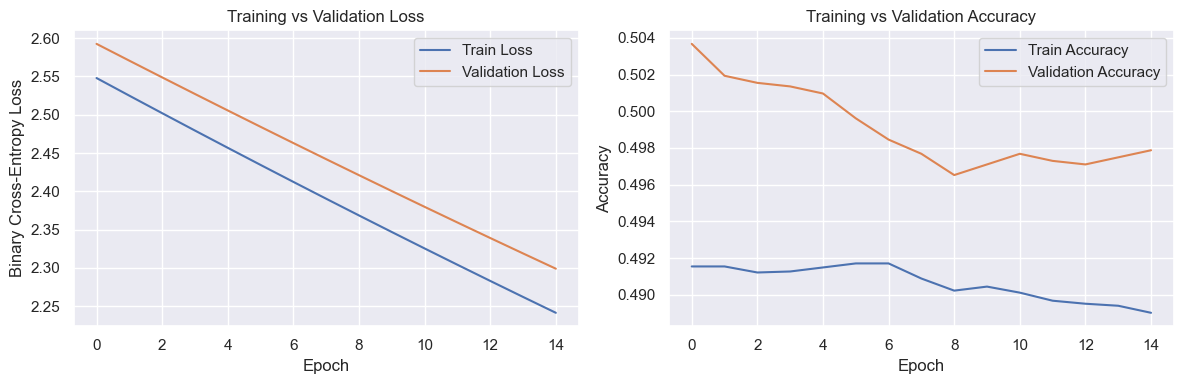

In [9]:
tf.random.set_seed(0)
# Build and compile model

model_tf = build_model(num_features=X_train_down.shape[1], learning_rate=0.0001)

# Fit the model

history = model_tf.fit(
    X_train_down, Y_train_down,
    epochs=15,
    batch_size=32,
    validation_data=(X_val, Y_val),
    verbose=1
)
# Generate (1,2) plot
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Hyperparameter Tuning

Trial 4 Complete [00h 01m 45s]
val_loss: 0.7227513790130615

Best val_loss So Far: 0.6178478598594666
Total elapsed time: 00h 06m 45s
Best learning rate: 0.01
First five weights: [-0.11714134 -0.11861538 -0.11269137 -0.13730301 -0.16052657]
Bias term: -0.04756395146250725
Final train loss: 0.6199
Final val loss:   0.6172
Val - Train loss diff: -0.0027


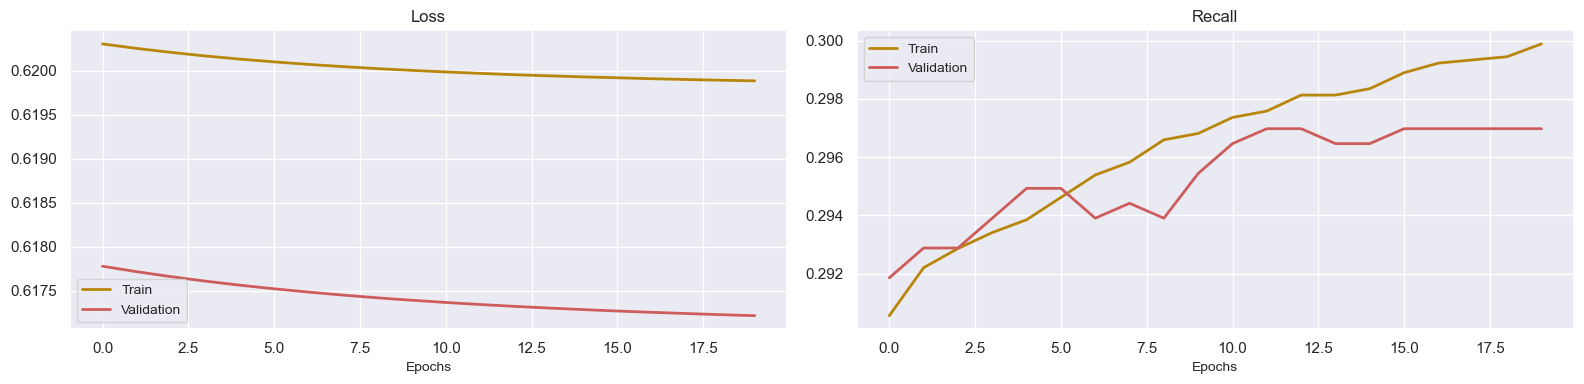

In [10]:
# 1) Define a tuner 
def build_model_tuner(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        units=1,
        input_shape=(X_train.shape[1],),
        activation="sigmoid",
        use_bias=True,
        kernel_initializer= tf.keras.initializers.GlorotUniform(),
        bias_initializer= tf.zeros_initializer(),
    ))

    # Tune the learning rate
    lr = hp.Choice("learning_rate", [0.1, 1e-4, 1e-3, 1e-2])
    optimizer = keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=optimizer,
                  loss="binary_crossentropy",
                  metrics=["recall"])
    return model

# 2) Create tuner 
tuner = kt.RandomSearch(
    build_model_tuner,
    objective="val_loss",
    max_trials=5,
    overwrite=True,
    directory="w207_project",
    project_name="final_project"
)

# 3) Run tuner search
tuner.search(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,   
    verbose=1
)

# 4) Retrieve best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best learning rate:", best_hp.get("learning_rate"))

best_model = tuner.get_best_models(1)[0]

# Re-train with best settings for clarity
history = best_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=32,
    verbose=0
)



# First five learned parameters (weights + bias)
W, b = best_model.layers[0].get_weights()
W = W.reshape(-1)
print("First five weights:", W[:5])
print("Bias term:", float(b[0]))

# Final-epoch loss on train and val
final_train_loss = history.history["loss"][-1]
final_val_loss   = history.history["val_loss"][-1]
print(f"Final train loss: {final_train_loss:.4f}")
print(f"Final val loss:   {final_val_loss:.4f}")

# 4) Difference between train and val
print(f"Val - Train loss diff: {final_val_loss - final_train_loss:.4f}")



#Plots
fig = plt.figure(figsize=(16, 4))

#loss
ax = fig.add_subplot(1, 2, 1)
plt.plot(history.history['loss'], lw=2, color='darkgoldenrod')
plt.plot(history.history['val_loss'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Loss')


#accuracy
ax = fig.add_subplot(1, 2, 2)
plt.plot(history.history['recall'], lw=2, color='darkgoldenrod')
plt.plot(history.history['val_recall'], lw=2, color='indianred')
plt.legend(['Train', 'Validation'], fontsize=10)
ax.set_xlabel('Epochs', size=10)
ax.set_title('Recall')


plt.tight_layout()
plt.show()


## Train, Val and Test Evaluation with The Best Model

### Train Evaluation

755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


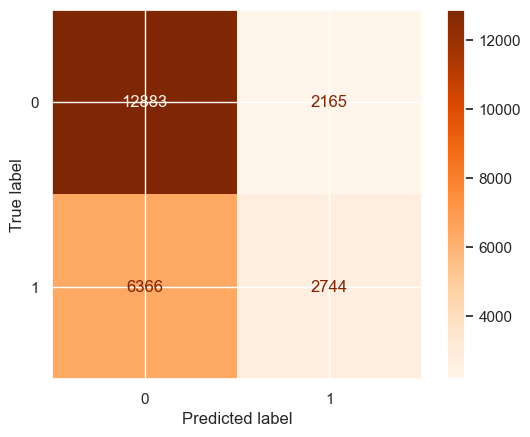

True_Positive: 2744 False_Negative: 6366 False_Positive: 2165 True_Negative: 12883
**************************************************
Train Set Performance:
**************************************************
             Evaluation Metric     Value
0         Risky Recall (Train)  0.301207
1     Non-Risky Recall (Train)  0.856127
2      Risky Precision (Train)  0.558973
3  Non-Risky Precision (Train)  0.669282
4       Risky F1 Score (Train)  0.391469
5   Non-Risky F1 Score (Train)  0.751261
6       Model Accuracy (Train)  0.646866


In [11]:
# Train predictions 
y_train_pred = (best_model.predict(X_train) >= 0.5).astype(int).ravel()
# Train cm
cm_train = sk_confusion_matrix(Y_train, y_train_pred)

ConfusionMatrixDisplay(confusion_matrix=cm_train).plot(cmap="Oranges")
plt.show()

tn_t, fp_t, fn_t, tp_t = cm_train.ravel()
print("True_Positive:", tp_t, "False_Negative:", fn_t, "False_Positive:", fp_t, "True_Negative:", tn_t)

risky_recall_train     = tp_t / (tp_t + fn_t) if (tp_t + fn_t) else 0.0
non_risky_recall_train = tn_t / (tn_t + fp_t) if (tn_t + fp_t) else 0.0

risky_precision_train =  tp_t / (tp_t + fp_t) if (tp_t + fp_t) else 0.0
non_risky_precision_train = tn_t / (tn_t + fn_t) if (tn_t + fn_t) else 0.0

f1_risky_train = 2*((risky_recall_train * risky_precision_train)/(risky_recall_train + risky_precision_train))
f1_non_risky_train = 2*((non_risky_recall_train * non_risky_precision_train)/(non_risky_recall_train + non_risky_precision_train))

model_acc_train     = (tp_t + tn_t) / (tn_t + fp_t + fn_t + tp_t) if (tn_t + fp_t + fn_t + tp_t) else 0.0

print('*' * 50)
print("Train Set Performance:")
print('*' * 50)
train_metrics = {
    "Evaluation Metric": [
        "Risky Recall (Train)", "Non-Risky Recall (Train)",
        "Risky Precision (Train)", "Non-Risky Precision (Train)",
        "Risky F1 Score (Train)", "Non-Risky F1 Score (Train)",
        "Model Accuracy (Train)"
    ],
    "Value": [
        risky_recall_train,
        non_risky_recall_train,
        risky_precision_train,
        non_risky_precision_train,
        f1_risky_train,
        f1_non_risky_train,
        model_acc_train
    ]
}

df_train = pd.DataFrame(train_metrics)
print(df_train)

### Val Evaluation

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


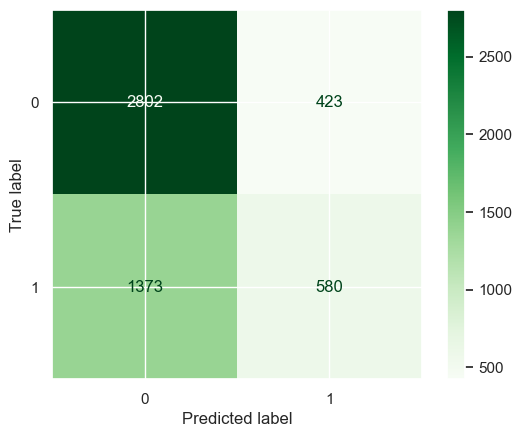

True_Positive: 580 False_Negative: 1373 False_Positive: 423 True_Negative: 2802
**************************************************
Val Set Performance:
**************************************************
           Evaluation Metric     Value
0         Risky Recall (Val)  0.296979
1     Non-Risky Recall (Val)  0.868837
2      Risky Precision (Val)  0.578265
3  Non-Risky Precision (Val)  0.671138
4       Risky F1 Score (Val)  0.392422
5   Non-Risky F1 Score (Val)  0.757297
6       Model Accuracy (Val)  0.653148


In [12]:
# Val predictions 
y_val_pred = (best_model.predict(X_val) >= 0.5).astype(int).ravel()
# Val cm
cm_val = sk_confusion_matrix(Y_val, y_val_pred)

ConfusionMatrixDisplay(confusion_matrix=cm_val).plot(cmap="Greens")
plt.show()

tn_v, fp_v, fn_v, tp_v = cm_val.ravel()
print("True_Positive:", tp_v, "False_Negative:", fn_v, "False_Positive:", fp_v, "True_Negative:", tn_v)

risky_recall_val     = tp_v / (tp_v + fn_v) if (tp_v + fn_v) else 0.0
non_risky_recall_val = tn_v / (tn_v + fp_v) if (tn_v + fp_v) else 0.0

risky_precision_val =  tp_v / (tp_v + fp_v) if (tp_v + fp_v) else 0.0
non_risky_precision_val = tn_v / (tn_v + fn_v) if (tn_v + fn_v) else 0.0

f1_risky_val = 2*((risky_recall_val * risky_precision_val)/(risky_recall_val + risky_precision_val))
f1_non_risky_val = 2*((non_risky_recall_val * non_risky_precision_val)/(non_risky_recall_val + non_risky_precision_val))

model_acc_val     = (tp_v + tn_v) / (tn_v + fp_v + fn_v + tp_v) if (tn_v + fp_v + fn_v + tp_v) else 0.0

print('*' * 50)
print("Val Set Performance:")
print('*' * 50)
val_metrics = {
    "Evaluation Metric": [
        "Risky Recall (Val)",
        "Non-Risky Recall (Val)",
        "Risky Precision (Val)",
        "Non-Risky Precision (Val)",
        "Risky F1 Score (Val)",
        "Non-Risky F1 Score (Val)",
        "Model Accuracy (Val)"
    ],
    "Value": [
        risky_recall_val,
        non_risky_recall_val,
        risky_precision_val,
        non_risky_precision_val,
        f1_risky_val,
        f1_non_risky_val,
        model_acc_val
    ]
}

val_df = pd.DataFrame(val_metrics)
print(val_df)

### Test Evaluation

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


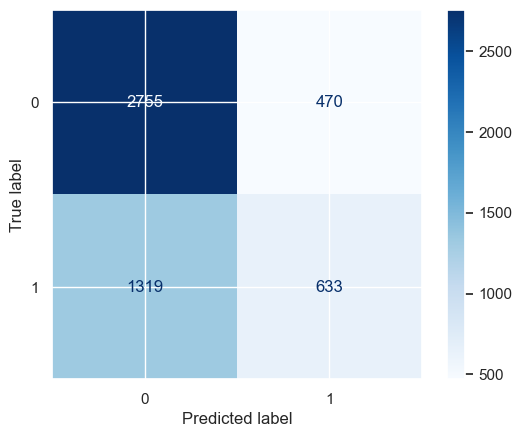

True_Positive: 633 False_Negative: 1319 False_Positive: 470 True_Negative: 2755
**************************************************
Test Set Performance:
**************************************************
            Evaluation Metric     Value
0         Risky Recall (Test)  0.324283
1     Non-Risky Recall (Test)  0.854264
2      Risky Precision (Test)  0.573889
3  Non-Risky Precision (Test)  0.676240
4       Risky F1 Score (Test)  0.391469
5   Non-Risky F1 Score (Test)  0.751261
6       Model Accuracy (Test)  0.654433


In [13]:

# Test predictions
y_pred = (best_model.predict(X_test) > 0.5).astype(int).ravel()
cm_test= sk_confusion_matrix(Y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm_test).plot(cmap="Blues")
plt.show()

# test cm
tn, fp, fn, tp = cm_test.ravel()
print("True_Positive:", tp, "False_Negative:", fn, "False_Positive:", fp, "True_Negative:", tn)


risky_acc = tp / (tp + fn) if (tp + fn) > 0 else 0   
non_risky_acc = tn / (tn + fp) if (tn + fp) > 0 else 0

risky_recall_test    = tp / (tp + fn) if (tp + fn) else 0.0
non_risky_recall_test = tn / (tn + fp) if (tn + fp) else 0.0

risky_precision_test =  tp / (tp + fp) if (tp + fp) else 0.0
non_risky_precision_test = tn / (tn + fn) if (tn + fn) else 0.0

f1_risky_test = 2*((risky_recall_train * risky_precision_train)/(risky_recall_train + risky_precision_train))
f1_non_risky_test = 2*((non_risky_recall_train * non_risky_precision_train)/(non_risky_recall_train + non_risky_precision_train))

model_acc_test    = (tp + tn) / (tn + fp + fn + tp) if (tn + fp + fn + tp) else 0.0

print('*' * 50)
print("Test Set Performance:")
print('*' * 50)
test_metrics = {
    "Evaluation Metric": [
        "Risky Recall (Test)",
        "Non-Risky Recall (Test)",
        "Risky Precision (Test)",
        "Non-Risky Precision (Test)",
        "Risky F1 Score (Test)",
        "Non-Risky F1 Score (Test)",
        "Model Accuracy (Test)"
    ],
    "Value": [
        risky_recall_test,
        non_risky_recall_test,
        risky_precision_test,
        non_risky_precision_test,
        f1_risky_test,
        f1_non_risky_test,
        model_acc_test
    ]
}

test_df = pd.DataFrame(test_metrics)
print(test_df)






## ROC Curve

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Random: ROC AUC=0.500
Logistic: ROC AUC=0.682


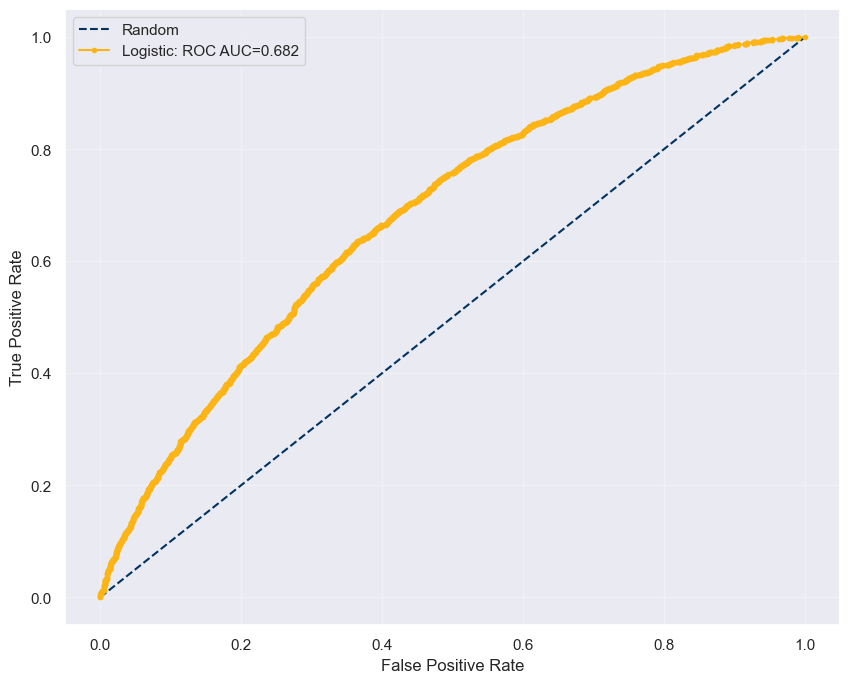

In [14]:
# predict probabilities
lr_probs = best_model.predict(X_test).ravel()
# generate a prediction (majority class)
ns_probs = [0 for _ in range(len(Y_test))]

# calculate scores
ns_auc = roc_auc_score(Y_test, ns_probs)
lr_auc = roc_auc_score(Y_test, lr_probs)

# summarize scores
print('Random: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y_test, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(10, 8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', color='#003262', label='Random')
plt.plot(lr_fpr, lr_tpr, color='#FDB515', marker='.', label=f'Logistic: ROC AUC={lr_auc:.3f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Subgroup Analysis

In [15]:
def subgroup_metrics(y_true, y_pred, name, n):
    return {
        'Subgroup': name, 'N': n,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1': f1_score(y_true, y_pred, zero_division=0)
    }

### Gender Analysis

In [16]:
gender_results = []
for val, name in [(0, 'Male'), (1, 'Female')]:
    mask = X_test['_SEX'] == val
    gender_results.append(subgroup_metrics(Y_test[mask], y_pred[mask], name, mask.sum()))

gender_df = pd.DataFrame(gender_results)
print("Performance by Gender:")
print(gender_df.to_string(index=False))

Performance by Gender:
Subgroup    N  Accuracy  Precision   Recall       F1
    Male 2357  0.596097   0.579559 0.458219 0.511795
  Female 2820  0.703191   0.553719 0.155272 0.242534


### Age Analysis

In [17]:
age_bins = [(18, 30, '18-29'), (30, 45, '30-44'), (45, 60, '45-59'), (60, 100, '60+')]
age_results = []
for lo, hi, name in age_bins:
    mask = (X_test_raw['_AGE80'] >= lo) & (X_test_raw['_AGE80']< hi)
    if mask.sum() > 0:
        age_results.append(subgroup_metrics(Y_test[mask], y_pred[mask], name, mask.sum()))

age_df = pd.DataFrame(age_results)
print("Performance by Age Group:")
print(age_df.to_string(index=False))

Performance by Age Group:
Subgroup    N  Accuracy  Precision   Recall       F1
   18-29  512  0.615234   0.584362 0.596639 0.590437
   30-44  851  0.619271   0.597734 0.536896 0.565684
   45-59 1117  0.622202   0.581897 0.293478 0.390173
     60+ 2697  0.686318   0.527273 0.168409 0.255282


### Race Analysis

In [18]:
race_results = []

# White
white = (X_test['race_2.0']==0) & (X_test['race_3.0']==0) & (X_test['race_4.0']==0) & (X_test['race_5.0']==0) & (X_test['race_6.0']==0)
race_results.append(subgroup_metrics(Y_test[white], y_pred[white], 'White', white.sum()))

# Black
black = X_test['race_2.0'] == 1
if black.sum() > 0:
    race_results.append(subgroup_metrics(Y_test[black], y_pred[black], 'Black', black.sum()))

# Other
other = (X_test['race_3.0']==1) | (X_test['race_4.0']==1) | (X_test['race_5.0']==1) | (X_test['race_6.0']==1)
if other.sum() > 0:
    race_results.append(subgroup_metrics(Y_test[other], y_pred[other], 'Other', other.sum()))

race_df = pd.DataFrame(race_results)
print("Performance by Race:")
print(race_df.to_string(index=False))

Performance by Race:
Subgroup    N  Accuracy  Precision   Recall       F1
   White 3092  0.620310   0.591058 0.404176 0.480071
   Black  542  0.699262   0.466667 0.131250 0.204878
   Other 1543  0.707064   0.496454 0.155211 0.236486


### Gender, Age, Race Visualization

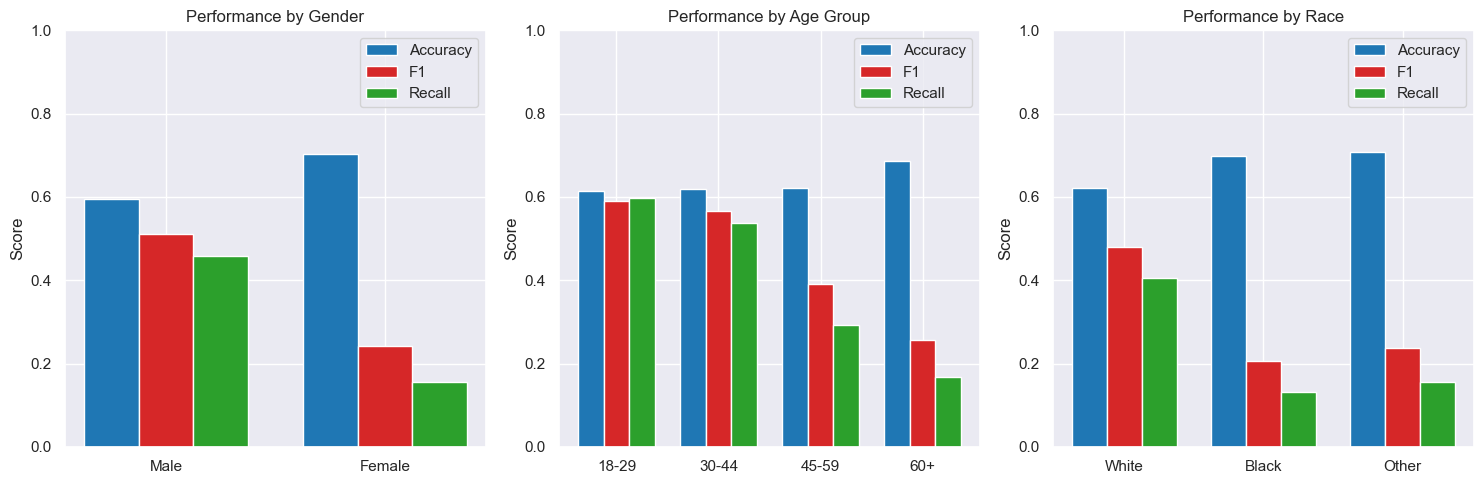

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (df, title) in zip(axes, [(gender_df, 'Gender'), (age_df, 'Age Group'), (race_df, 'Race')]):
    x = np.arange(len(df))
    w = 0.25
    ax.bar(x - w, df['Accuracy'], w, label='Accuracy', color='#1f77b4')
    ax.bar(x, df['F1'], w, label='F1', color='#d62728')
    ax.bar(x + w, df['Recall'], w, label='Recall', color='#2ca02c')
    ax.set_xticks(x)
    ax.set_xticklabels(df['Subgroup'])
    ax.set_ylabel('Score')
    ax.set_title(f'Performance by {title}')
    ax.legend()
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()